In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import community
import seaborn as sns
import random 
import numpy as np
import cython
from fa2 import ForceAtlas2
from time import time
from collections import Counter
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

# Community Detection on IMDB Movies
In this notebook we consider movies as nodes in a graph, with an edge between two nodes if the two movies share a common actor/actress. The number of common actors/actresses is the weight of this edge. We perform community detection on the resulting graph to see if movies of a particular genre have common actors. (ie. Do actors specialise in particular genres?)

## Import Data from IMDB (https://datasets.imdbws.com/)

In [2]:
name_basics = pd.read_csv("name.basics.tsv.gz", sep = "\t", na_values=["\\N"], index_col="nconst")
title_basics = pd.read_csv("title.basics.tsv.gz", sep = "\t", na_values=["\\N"], index_col="tconst", low_memory=False)

In [3]:
name_basics.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0072308,tt0050419,tt0043044,tt0053137"
nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0117057,tt0071877,tt0038355"
nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0059956,tt0057345,tt0054452,tt0049189"
nm0000004,John Belushi,1949.0,1982.0,"actor,writer,soundtrack","tt0080455,tt0078723,tt0077975,tt0072562"
nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0050976,tt0083922,tt0060827,tt0050986"


In [4]:
title_basics.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,Short


## Sample the Dataset

In [5]:
movies=title_basics.query("titleType == 'movie'")
print('Total # of movies', len(movies))

movies=movies.sample(50000)
movies.head()

Total # of movies 496405


,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tconst,,,,,,,,
tt1588325,movie,Within Sight of Shore,Within Sight of Shore,0,2010.0,NaN,44,"Documentary,History,Music"
tt4010054,movie,Vacation in Slum,Vacation in Slum,0,1998.0,NaN,45,Documentary
tt3443538,movie,TSG,To Say Goodbye,0,2014.0,NaN,100,Drama
tt7639838,movie,Akatsuhi no naka no kao,Akatsuhi no naka no kao,0,1927.0,NaN,NaN,Drama
tt0035031,movie,Man with Two Lives,Man with Two Lives,0,1942.0,NaN,65,"Horror,Thriller"


## Build Graph

In [6]:
start = time()
G = nx.Graph()

for i,row in movies.iterrows():
    try:
        G.add_node(i, title=row['primaryTitle'], genres=row['genres'].split(','))
    except:
        G.add_node(i, title=row['primaryTitle'], genres=[])

for i,row in name_basics.iterrows():
    if type(row['knownForTitles'])==str:
        pairs = combinations(row['knownForTitles'].split(','), 2)
        for u,v in pairs:
            if G.has_node(u) and G.has_node(v):
                if G.has_edge(u,v):
                    G[u][v]['weight'] = G[u][v]['weight'] + 1
                else:
                    G.add_edge(u,v, weight=1)

print(time()-start, 'seconds')
print(nx.info(G))

503.64515256881714 seconds
Name: 
Type: Graph
Number of nodes: 50000
Number of edges: 33769
Average degree:   1.3508


nx.k_core returns the maximal subgraph of minimum degree at least $k$. This improves community detection.

In [7]:
G=nx.k_core(G,k=3)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3622
Number of edges: 13838
Average degree:   7.6411


## Perform Community Detection

In [8]:
partition = community.best_partition(G)

In [9]:
#positioning
init_pos = { i : (random.random(), random.random()) for i in G.nodes()}
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=2.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G, init_pos, iterations=500) 

100%|██████████| 500/500 [00:57<00:00,  8.67it/s]


BarnesHut Approximation  took  10.11  seconds
Repulsion forces  took  45.18  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.46  seconds
AdjustSpeedAndApplyForces step  took  0.76  seconds


In [10]:
with open('layout_G', 'w') as f:
    f.write(str(pos))

In [11]:
from ast import literal_eval
with open('layout_G', 'r') as f:
    pos=literal_eval(f.read())

In [12]:
genres=Counter(sum([g.split(',') for g in movies.genres if type(g)==str],[]))
genres

Counter({'Documentary': 9264,
         'History': 1065,
         'Music': 930,
         'Drama': 17093,
         'Horror': 2586,
         'Thriller': 3152,
         'Comedy': 8599,
         'Reality-TV': 14,
         'Biography': 1384,
         'Family': 1392,
         'Action': 4229,
         'Crime': 2728,
         'Romance': 3753,
         'Musical': 868,
         'Adventure': 2169,
         'War': 814,
         'Sci-Fi': 1044,
         'Fantasy': 1118,
         'Adult': 788,
         'Mystery': 1219,
         'News': 155,
         'Western': 703,
         'Sport': 434,
         'Animation': 594,
         'Film-Noir': 79,
         'Short': 2,
         'Talk-Show': 5,
         'Game-Show': 3})

In [18]:
size = len(set(partition.values()))
cmap = sns.color_palette("hls", n_colors=size)

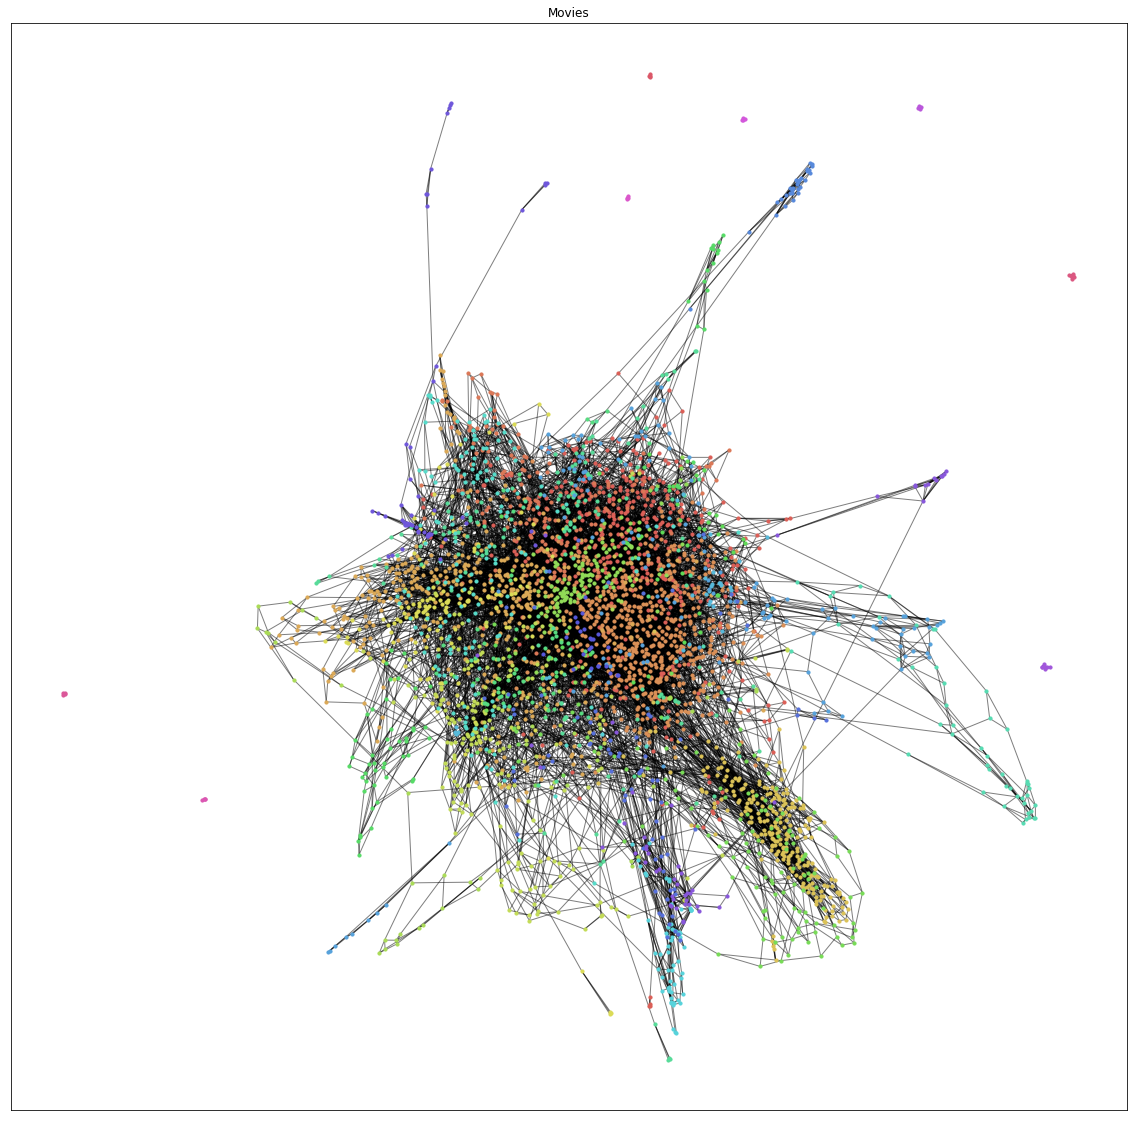

In [19]:
#drawing
plt.figure(figsize=(20,20))

for i,com in enumerate(set(partition.values())) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 10, node_color = cmap[i])

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.title("Movies")

plt.savefig("G.png", format = "png")
plt.show()

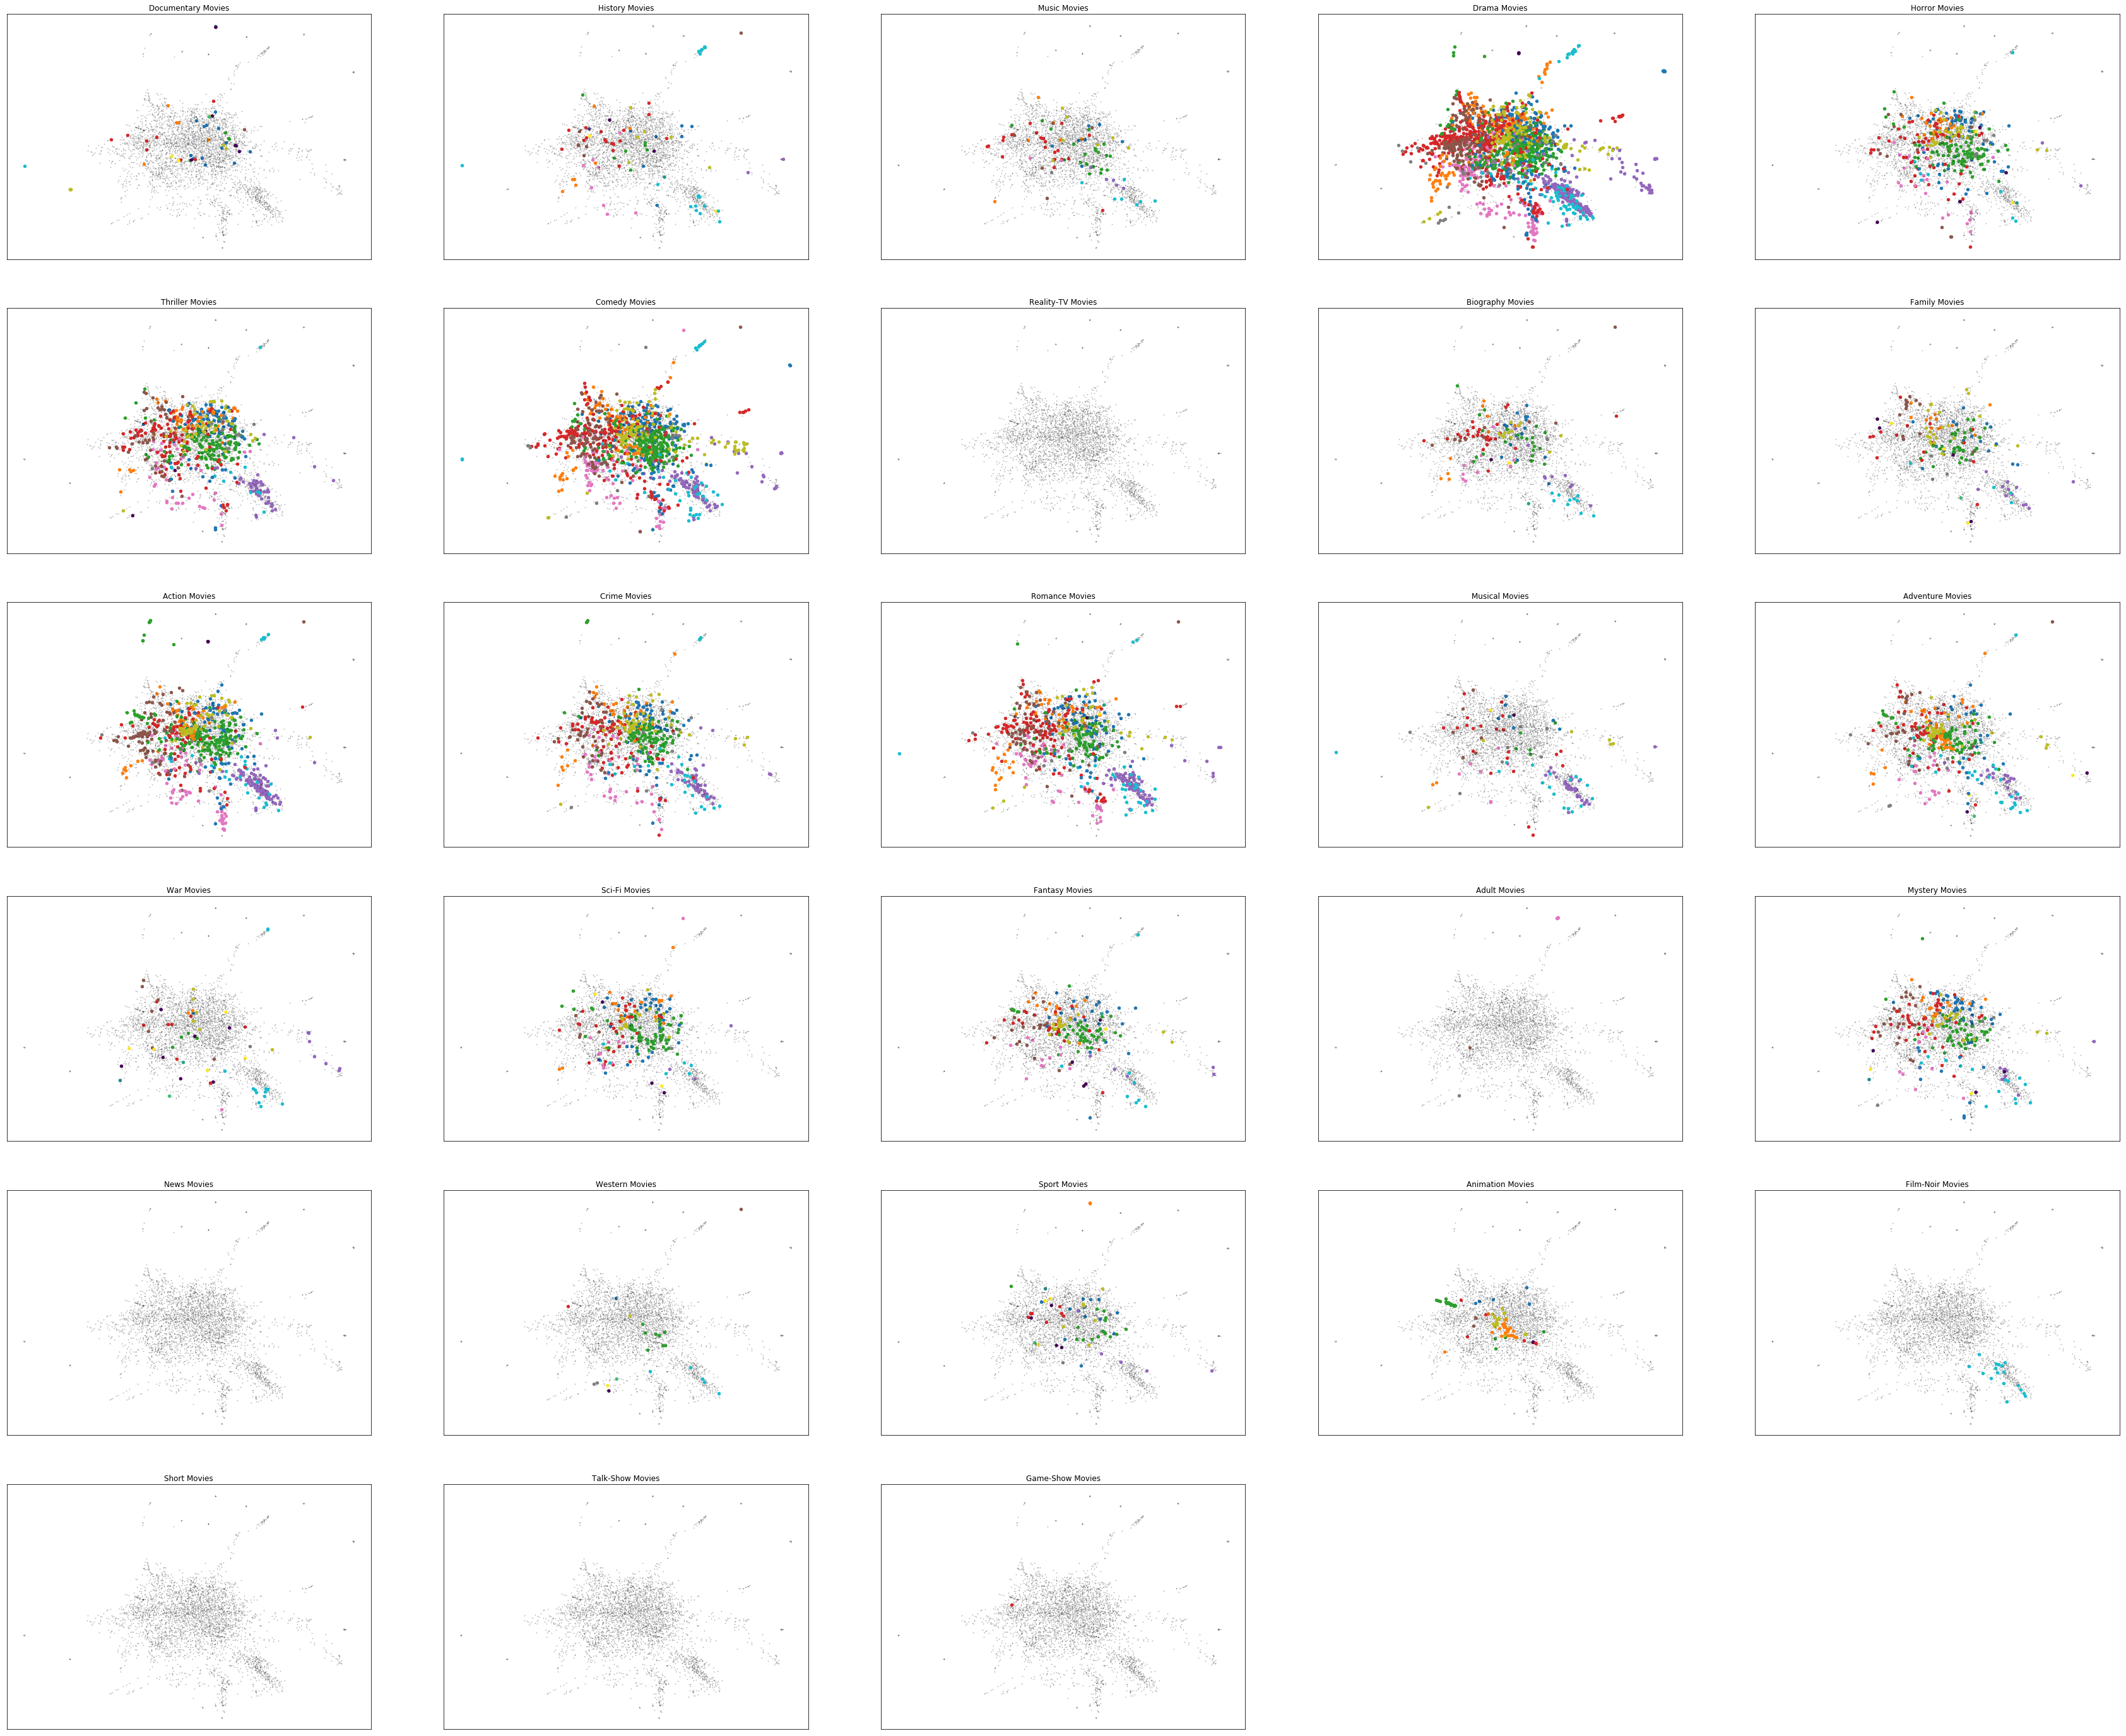

In [22]:
#drawing
plt.figure(figsize=(60,50))

for i,focus_genre in enumerate(genres.keys()):
    plt.subplot(6,5,i+1)

    for i,com in enumerate(set(partition.values())) :
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        list_nodes0 = [n for n in list_nodes if not focus_genre in G.nodes[n]['genres']]
        list_nodes1 = [n for n in list_nodes if focus_genre in G.nodes[n]['genres']]
        nx.draw_networkx_nodes(G, pos, list_nodes0, node_size = 1, node_color = 'black', alpha=0.2)
        nx.draw_networkx_nodes(G, pos, list_nodes1, node_size = 20, node_color = cmap[i])

    #nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(focus_genre + " Movies")


plt.savefig("G_byGenre.png", format = "png")
plt.show()

In [ ]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_traces=[]
for i,focus_genre in enumerate(genres.keys()):
    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            color=[],
            size=10,
        )
    )
        
    for i,com in enumerate(set(partition.values())) :
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        for node in list_nodes:
            x, y = pos[node]
            node_trace['x'] += tuple([x])
            node_trace['y'] += tuple([y])
            node_trace['marker']['color'] += tuple([cmap[i]])
            node_trace['text']+=tuple([G.node[node]['title']])

        
    node_traces.append(node_trace)
    
fig = go.Figure(data=[edge_trace]+node_traces,
             layout=go.Layout(
                title='Movies by Genre',
                titlefont=dict(size=16),
                showlegend=True,
                hovermode='closest',
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='G_plotly')